In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
# %matplotlib inline
%config Completer.use_jedi = False

In [2]:
from datasets import InsectImgDataset
from utils import *
import pandas as pd
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt

setting = 'photobox'
if setting == 'photobox':
    ext = '.png'
elif setting == 'fuji':
    ext = '.jpg'

Available workers: 16


In [3]:
dfs = InsectImgDataset(directory=DATA_DIR, ext=ext, setting=setting)
dfs.extract_df_info()

Extracting info from filenames..: 100%|████████████████████████████████████████████████████| 30625/30625 [00:03<00:00, 7925.26it/s]


In [4]:

dfs.df.label.value_counts()

wmv         5820
v           5289
c           4575
sw          3025
bl          2406
t           2390
wrl         1874
m           1552
k           1087
sp          1026
wswl         711
v(cy)        190
grv          183
bv           163
w            144
st           104
gv            66
lhb           10
ONBEKEND       9
sl             1
Name: label, dtype: int64

In [5]:
dfs.df.label = dfs.df.label.apply(lambda x: 'v' if x=='v(cy)' else x)
dfs.df.label = dfs.df.label.apply(lambda x: 'v' if x=='bv' else x)
insects = ['v', 'wmv', 'c', 'sw', 't', 'bl', 'm', 'k', 'wrl', 'sp', 'wswl','other']
dfs.df.label = dfs.df.label.apply(lambda x: 'other' if x not in insects else x)
dfs.df = dfs.df[dfs.df.label.isin(insects)]
dfs.df = dfs.df[~dfs.df['label'].isin(['st','vuil'])]
dfs.df.reset_index(drop=True, inplace=True)
dfs.df.label.value_counts()

wmv      5820
v        5642
c        4575
sw       3025
bl       2406
t        2390
wrl      1874
m        1552
k        1087
sp       1026
wswl      711
other     517
Name: label, dtype: int64

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 73.86it/s]


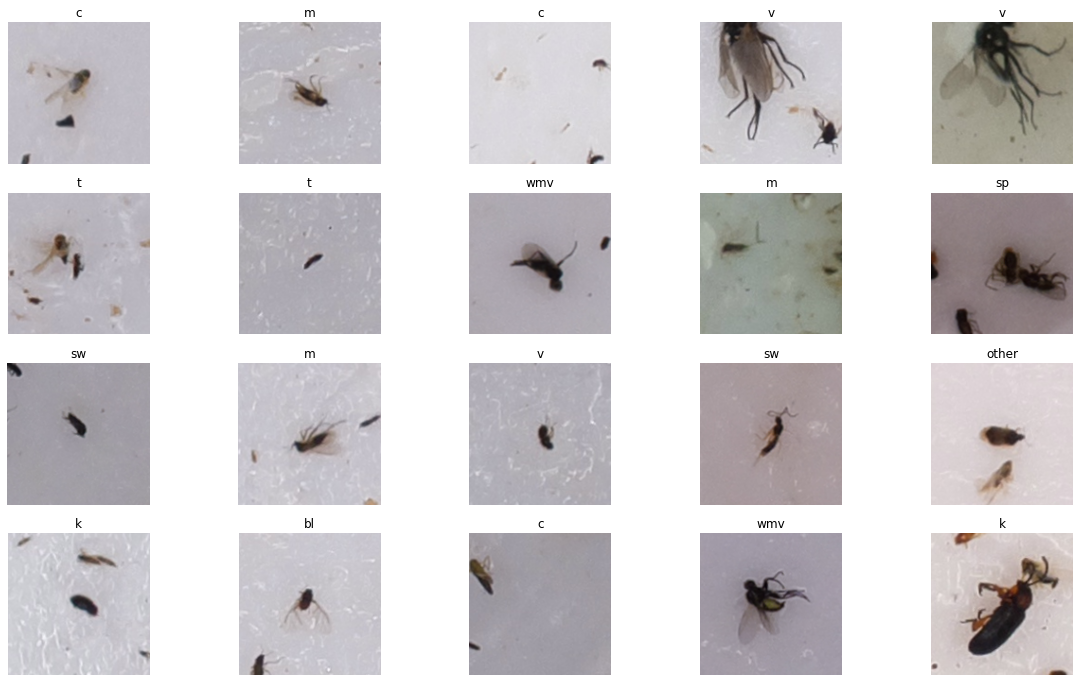

In [6]:
dfs.plot_samples()

# Extra feature collection

In [85]:
batch_size=64
dloader = DataLoader(dfs, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [141]:
import torch.nn as nn
import torchvision.transforms.functional as fn

n_modelfeats = 512
model = model_selector('densenet121', pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
                        nn.Linear(num_ftrs,n_modelfeats))
model.eval()
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [142]:
l_blur_factors = [0]*len(dfs)
l_meansRGB = [0]*len(dfs)
l_stdsRGB = [0]*len(dfs)
l_nb_contours, l_mean_cnt_area, l_mean_cnt_perimeter, l_std_cnt_area, l_std_cnt_perimeter = [0]*len(dfs),[0]*len(dfs),[0]*len(dfs),[0]*len(dfs),[0]*len(dfs)
m_feats = np.zeros((len(dfs),n_modelfeats))

c=0
for x,l,imgname,platename,filename,plate_idx,location,date,year,xtra,width,height in tqdm(dloader, total=len(dfs)//batch_size, desc='Collecting all data from the dataloader..'):
    for i,f in enumerate(filename):
        tmp = fn.to_tensor(fn.to_pil_image(x[i].squeeze()))
        with torch.no_grad():
            model_features = model(torch.unsqueeze(tmp,0)).numpy().squeeze()
        m_feats[c] = model_features
        meanRGB, stdRGB = calc_mean_RGB_vals(f)
        nb_contours, mean_cnt_area, mean_cnt_perimeter, std_cnt_area, std_cnt_perimeter = calc_contour_features(f)
        l_blur_factors[c] = calc_variance_of_laplacian(f)
        l_meansRGB[c] = meanRGB
        l_stdsRGB[c] = stdRGB
        l_nb_contours[c] = nb_contours
        l_mean_cnt_area[c] = mean_cnt_area
        l_mean_cnt_perimeter[c] = mean_cnt_perimeter
        l_std_cnt_area[c] = std_cnt_area
        l_std_cnt_perimeter[c] = std_cnt_perimeter
        c+=1

  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kalfasyan/anaconda3/envs/bugai/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/kalfasyan/anaconda3/envs/bugai/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/kalfasyan/anaconda3/envs/bugai/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/kalfasyan/anaconda3/envs/bugai/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [143]:
df_modelfeats = pd.DataFrame(m_feats)
df_modelfeats.columns = [f"feat_{i}" for i in range(n_modelfeats)]

df_rgb = pd.DataFrame(l_meansRGB, columns=['R','G','B'])
df_feats = pd.DataFrame({'blur': l_blur_factors, 
                        'nb_contours': l_nb_contours,
                        'mean_cnt_area': l_mean_cnt_area,
                        'mean_cnt_perimeter': l_mean_cnt_perimeter,
                        'std_cnt_area': l_std_cnt_area,
                        'std_cnt_perimeter': l_std_cnt_perimeter})
df_feats = pd.concat([df_feats, df_rgb], axis=1)
feature_columns = df_feats.columns


df = pd.concat([dfs.df, df_feats], axis=1)
df = pd.concat([df,df_modelfeats],axis=1)
df.sort_values(by='label', inplace=True)

df = df[~df.label.isin(['gv','sl'])]

insect_classes = df.label.unique().tolist()

df

,filename,label,imgname,platename,year,location,date,xtra,plate_idx,blur,...,feat_502,feat_503,feat_504,feat_505,feat_506,feat_507,feat_508,feat_509,feat_510,feat_511
0,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2020_UNDISTORTED_herent_w28_1-90_4056x3040_202...,UNDISTORTED_herent_w28_1-90_4056x3040_20200703...,2020,herent,w28,1-90,14131,42.842744,...,0.128541,-0.374838,-0.548748,0.390531,-0.261373,-0.126287,-0.529007,-0.596750,0.161571,-0.057416
1600,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2021_UNDISTORTED_arc_C_w23_4056x3040.png_bl_9480,UNDISTORTED_arc_C_w23_4056x3040.png,2021,arc,w23,c,9480,29.410180,...,0.051194,-0.253381,-0.799281,-0.027871,-0.407202,-0.211582,-1.565096,-0.915060,0.492343,0.608792
1601,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2021_UNDISTORTED_arc_C_w23_4056x3040.png_bl_9485,UNDISTORTED_arc_C_w23_4056x3040.png,2021,arc,w23,c,9485,19.875911,...,0.273103,-0.487486,-0.386459,-0.097179,-0.303009,-0.344621,-0.919809,-0.473598,0.168708,0.149953
1602,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2021_UNDISTORTED_arc_C_w23_4056x3040.png_bl_9486,UNDISTORTED_arc_C_w23_4056x3040.png,2021,arc,w23,c,9486,23.337022,...,0.247305,-0.360344,-0.447160,0.242383,-0.289671,-0.150837,-1.218344,-0.071597,0.099308,0.402249
1603,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2021_UNDISTORTED_arc_C_w23_4056x3040.png_bl_9487,UNDISTORTED_arc_C_w23_4056x3040.png,2021,arc,w23,c,9487,19.561551,...,0.216467,-0.363228,-0.257236,0.134442,-0.283318,-0.371590,-0.845957,-0.477320,0.289946,0.053985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30153,/mnt/EE7455C074558BE9/backups/data_backups/ima...,wswl,2021_UNDISTORTED_landen_B_w24_4056x3040.png_ws...,UNDISTORTED_landen_B_w24_4056x3040.png,2021,landen,w24,b,8220,22.121750,...,0.230187,-0.356656,-0.347953,0.117508,-0.323053,-0.191995,-0.916356,-0.313925,0.056618,0.362654
30154,/mnt/EE7455C074558BE9/backups/data_backups/ima...,wswl,2021_UNDISTORTED_landen_B_w24_4056x3040.png_ws...,UNDISTORTED_landen_B_w24_4056x3040.png,2021,landen,w24,b,8221,20.476336,...,0.401447,-0.275532,-0.212338,0.159578,-0.346590,-0.365124,-1.103297,-0.481778,0.218484,0.626297
30155,/mnt/EE7455C074558BE9/backups/data_backups/ima...,wswl,2021_UNDISTORTED_landen_B_w25_4056x3040.png_ws...,UNDISTORTED_landen_B_w25_4056x3040.png,2021,landen,w25,b,144,32.118978,...,0.813952,-0.501034,-0.802594,0.071949,-0.081704,-0.590627,-1.307144,-0.683355,-0.529263,0.907131
30135,/mnt/EE7455C074558BE9/backups/data_backups/ima...,wswl,2021_UNDISTORTED_brainelal_c_w40_4056x3040.png...,UNDISTORTED_brainelal_c_w40_4056x3040.png,2021,brainelalleud,w40,c,4228,24.167775,...,0.389006,-0.286963,-0.712225,-0.109528,-0.244417,-0.553644,-1.349699,-0.423571,0.366311,1.233744


# Outlier detection

### Performed per insect class

In [156]:
l_outlier_features = df_modelfeats.columns.tolist() + ['blur', 'R','G','B', 'nb_contours']#, 'mean_cnt_area', 'mean_cnt_perimeter', 'std_cnt_area', 'std_cnt_perimeter']

def class_outliers(df, features, insect='bl'):
    df = df[df.label==insect]
    outlier, outlier_score = detect_outliers(df[features].fillna(0).values, algorithm='KNN')    
    return outlier, outlier_score

df['knn_outlier'], df['knn_outlier_score'] = 0,0
outliers, scores = [],[]
for ins in tqdm(insect_classes, total=len(insect_classes)):
    out, scr = class_outliers(df, l_outlier_features, insect=ins)
    assert len(out) == df[df.label==ins].shape[0]
    outliers.extend(out)
    scores.extend(scr)
    
df['knn_outlier'], df['knn_outlier_score'] = outliers, scores

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:09<00:00,  1.21it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 39.44it/s]


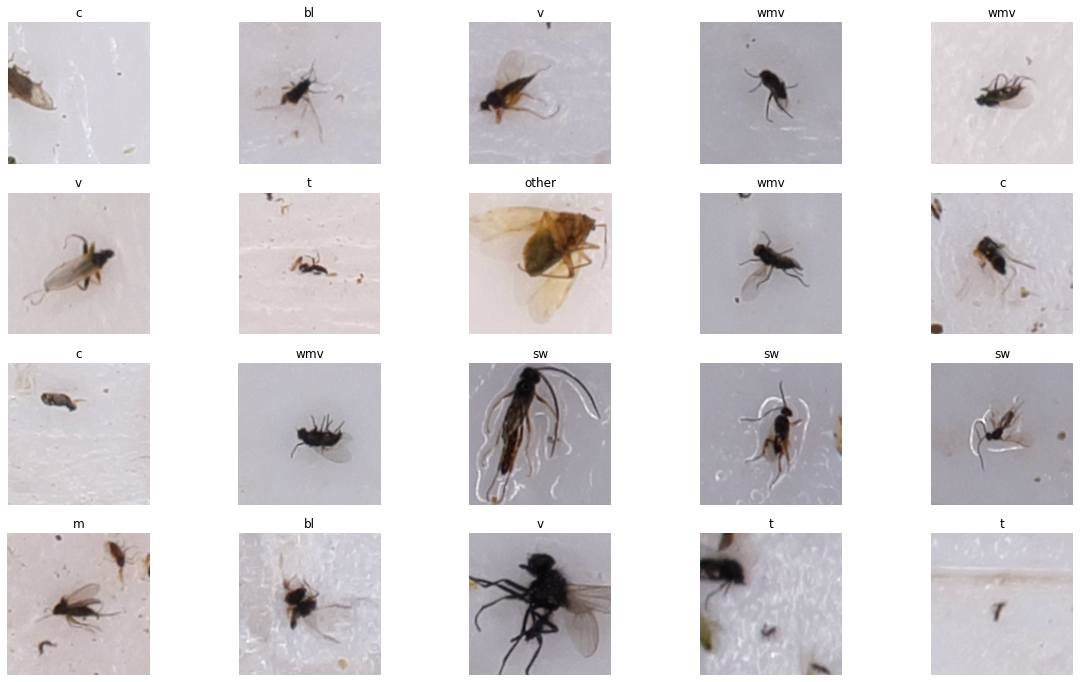

In [160]:
dfs.plot_samples(df[df.knn_outlier==1].sample(20))

In [161]:
print(f"Total of {df[df.knn_outlier==1].shape[0]} outliers found. (# of all datapoints: {df.shape[0]})")
df[df.knn_outlier==1].label.value_counts()

Total of 3067 outliers found. (# of all datapoints: 30625)


wmv      582
v        565
c        458
sw       303
bl       241
t        239
wrl      188
m        156
k        109
sp       103
wswl      71
other     52
Name: label, dtype: int64

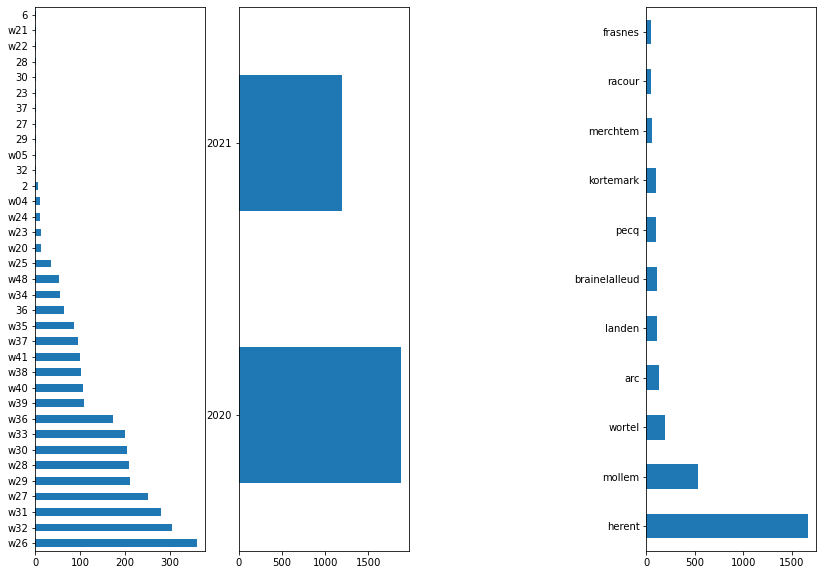

In [71]:
plt.figure(figsize=(24,12))
plt.subplot(1,4,1);
df[df.knn_outlier==1].date.value_counts().plot(kind='barh', figsize=(14,10));
plt.subplot(1,4,2);
df[df.knn_outlier==1].year.value_counts().plot(kind='barh', figsize=(14,10));
plt.subplot(1,4,4);
df[df.knn_outlier==1].location.value_counts().plot(kind='barh', figsize=(14,10));

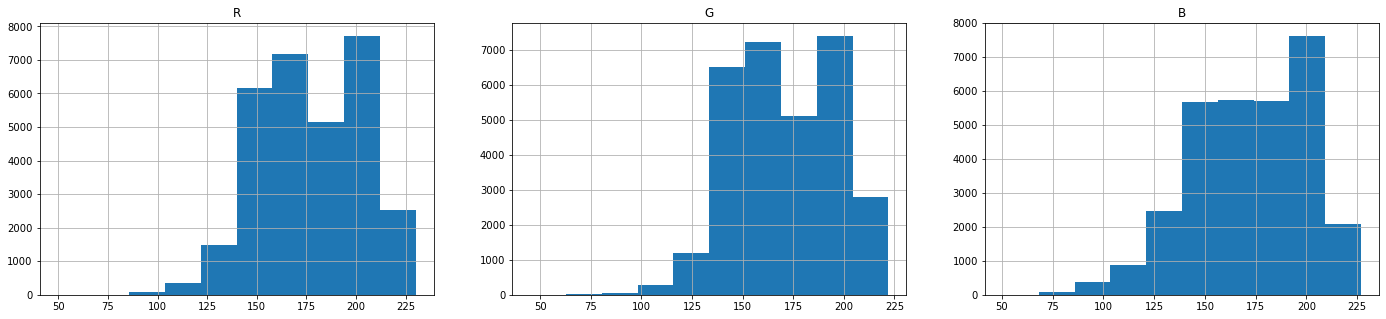

In [163]:
plt.figure(figsize=(24,5))
plt.subplot(1,3,1);
df.R.hist();plt.title('R')
plt.subplot(1,3,2);
df.G.hist();plt.title('G')
plt.subplot(1,3,3);
df.B.hist();plt.title('B');

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.14it/s]


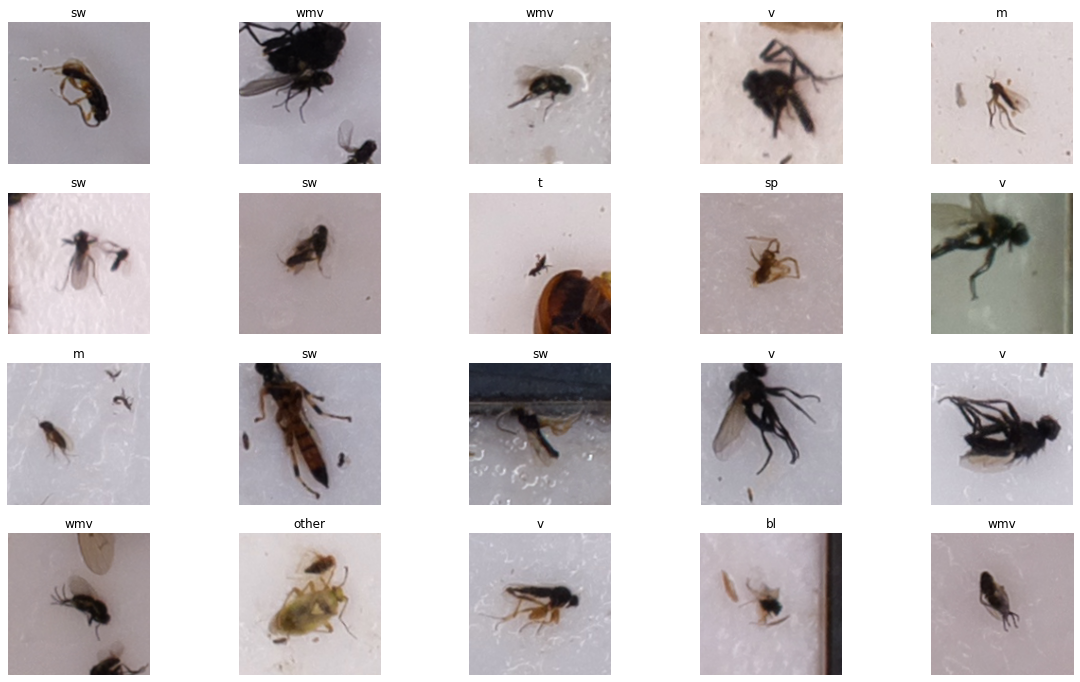

In [164]:
selection = 'knn_outlier==1'
# selection = 'knn_outlier==1 & label==\'wmv\''
dfs.plot_samples(df.query(selection).sample(20))

In [74]:
df.query(selection).date.value_counts()

w26    359
w32    303
w31    279
w27    251
w29    211
w28    209
w30    204
w33    199
w36    174
w39    109
w40    107
w38    102
w41     99
w37     95
w35     87
36      64
w34     56
w48     52
w25     35
w20     14
w23     13
w24     12
w04     11
2        6
32       3
w05      2
29       2
27       2
37       1
23       1
30       1
28       1
w22      1
w21      1
6        1
Name: date, dtype: int64

# CALCULAE IF INSECT IS CLOSER TO THE EDGE OF FOTO

In [75]:
# df[df.knn_outlier==0]

In [76]:
df['plate_idx'] = df['plate_idx'].astype('int64')
df['year'] = df['year'].astype('int64')

df_allinfo = pd.read_csv("../stickybugs/modelling/df_allinfo.csv", index_col='Unnamed: 0')
df_allinfo['plate_idx'] = df_allinfo.index.values

In [77]:
if setting == 'photobox':
    df_all = pd.merge(left=df, right=df_allinfo, on=['plate_idx','platename','year'])
    assert df_all[df_all.date.apply(lambda x: not x.startswith('w'))].location.unique()[0] == 'wortel', "There are dates not starting with w that are not wortel."
    df_all['date'] = df_all['date'].apply(lambda x: x.replace(x,'w00') if not x.startswith('w') else x)
    print(df_allinfo.year.value_counts())
    print(df.year.value_counts())
    print(df_all.date.value_counts())
    df_all.to_parquet(f'{SAVE_DIR}/df_preparation_{setting}.parquet')
elif setting=='fuji':
    df.to_parquet(f'{SAVE_DIR}/df_preparation_{setting}.parquet')

2020    19539
2021    11086
Name: year, dtype: int64
2020    19539
2021    11086
Name: year, dtype: int64
w32    4103
w31    3516
w27    3044
w28    2299
w29    2212
w33    2107
w30    2079
w36    1476
w26    1111
w38    1065
w35     992
w34     973
w39     897
w40     890
w00     857
w37     850
w48     595
w24     450
w25     396
w41     373
w23     198
w20      49
w04      42
w22      35
w05      15
w21       1
Name: date, dtype: int64


In [78]:
import os
os.listdir(SAVE_DIR)

['efficientnetb1_photobox.pth.tar',
 'densenet121_photobox.pth.tar',
 'densenet121_photobox_best.pth.tar',
 'densenet169_photobox.pth.tar',
 'densenet169_photobox_best.pth.tar',
 'df_preparation_fuji.parquet',
 'df_preparation_photobox.parquet',
 'df_test_fuji.parquet',
 'df_test_photobox.parquet',
 'df_train_fuji.parquet',
 'df_train_photobox.parquet',
 'df_val_fuji.parquet',
 'df_val_photobox.parquet',
 'efficientnetb0_photobox.pth.tar',
 'efficientnetb0_photobox_best.pth.tar',
 'efficientnetb1_photobox_best.pth.tar',
 'mobilenetv2_photobox.pth.tar',
 'mobilenetv2_photobox_best.pth.tar',
 'mobilenetv3l_photobox.pth.tar',
 'mobilenetv3l_photobox_best.pth.tar',
 'resnet101_photobox.pth.tar',
 'resnet101_photobox_best.pth.tar',
 'resnet50_photobox.pth.tar',
 'resnet50_photobox_best.pth.tar',
 'vgg16_fuji.pth.tar',
 'vgg16_fuji_best.pth.tar',
 'vgg16_photobox.pth.tar',
 'vgg16_photobox_best.pth.tar',
 'vgg19_photobox.pth.tar',
 'vgg19_photobox_best.pth.tar']

In [79]:
def find_edge_cases(df, dist_threshold=5):
    edge_cases, edge_x, edge_y = [],[],[]
    for i,row in tqdm(df.iterrows()):
        plate_width = row.plate_width
        plate_height = row.plate_height

        x = row.yolo_x * plate_width
        y = row.yolo_y * plate_height

        edge_x.append(x)
        edge_y.append(y)
        
        if x > (plate_width-dist_threshold) or x < dist_threshold or y > (plate_height-dist_threshold) or y < dist_threshold:
            edge_cases.append(True)
        else:
            edge_cases.append(False)
    df['edge'] = edge_cases
    df['edge_x'] = edge_x
    df['edge_y'] = edge_y
    print(df[df['edge']==True].shape)
    return df

def plot_samples(df=pd.DataFrame(), noaxis=True, title='label'):
    seed=42
    df.reset_index(drop=True, inplace=True)
    #df = df.sample(14, replace=False, random_state=seed).reset_index(drop=True)

    plt.figure(figsize=(20,12))

    for i in tqdm(range(14)):
        plt.subplot(4,5,i+1)
        img = read_image(df.loc[i].filename)
        plt.imshow(img);
        if title == 'label':
            plt.title(df.loc[i].label)
        if noaxis:
            plt.axis('off')

In [80]:
find_edge_cases(df_all)

30625it [00:01, 17672.80it/s]

(0, 41)


,filename,label,imgname,platename,year,location,date,xtra,plate_idx,blur,...,platename_tmp,platename_ann,filepath_ann,yolo_x,yolo_y,yolo_width,yolo_height,edge,edge_x,edge_y
0,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2020_UNDISTORTED_herent_w28_1-90_4056x3040_202...,UNDISTORTED_herent_w28_1-90_4056x3040_20200703...,2020,herent,w28,1-90,14131,42.842744,...,UNDISTORTED_herent_w28_1-90_4056x3040_20200703...,UNDISTORTED_herent_w28_1-90_4056x3040_20200703...,/home/kalfasyan/projects/stickybugs/processing...,0.109589,0.735068,0.037360,0.050050,False,440.0,2203.0
1,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2021_UNDISTORTED_arc_C_w23_4056x3040.png_bl_9480,UNDISTORTED_arc_C_w23_4056x3040.png,2021,arc,w23,c,9480,29.410180,...,UNDISTORTED_arc_C_w23_4056x3040,UNDISTORTED_arc_C_w23_4056x3040,/home/kalfasyan/projects/stickybugs/processing...,0.805507,0.209715,0.037212,0.049735,False,3247.0,632.5
2,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2021_UNDISTORTED_arc_C_w23_4056x3040.png_bl_9485,UNDISTORTED_arc_C_w23_4056x3040.png,2021,arc,w23,c,9485,19.875911,...,UNDISTORTED_arc_C_w23_4056x3040,UNDISTORTED_arc_C_w23_4056x3040,/home/kalfasyan/projects/stickybugs/processing...,0.369883,0.354443,0.037212,0.049735,False,1491.0,1069.0
3,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2021_UNDISTORTED_arc_C_w23_4056x3040.png_bl_9486,UNDISTORTED_arc_C_w23_4056x3040.png,2021,arc,w23,c,9486,23.337022,...,UNDISTORTED_arc_C_w23_4056x3040,UNDISTORTED_arc_C_w23_4056x3040,/home/kalfasyan/projects/stickybugs/processing...,0.367031,0.497679,0.037212,0.049735,False,1479.5,1501.0
4,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2021_UNDISTORTED_arc_C_w23_4056x3040.png_bl_9487,UNDISTORTED_arc_C_w23_4056x3040.png,2021,arc,w23,c,9487,19.561551,...,UNDISTORTED_arc_C_w23_4056x3040,UNDISTORTED_arc_C_w23_4056x3040,/home/kalfasyan/projects/stickybugs/processing...,0.405855,0.500829,0.037212,0.049735,False,1636.0,1510.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30620,/mnt/EE7455C074558BE9/backups/data_backups/ima...,wswl,2021_UNDISTORTED_landen_B_w24_4056x3040.png_ws...,UNDISTORTED_landen_B_w24_4056x3040.png,2021,landen,w24,b,8220,22.121750,...,UNDISTORTED_landen_B_w24_4056x3040,UNDISTORTED_landen_B_w24_4056x3040,/home/kalfasyan/projects/stickybugs/processing...,0.793476,0.202918,0.037212,0.049735,False,3198.5,612.0
30621,/mnt/EE7455C074558BE9/backups/data_backups/ima...,wswl,2021_UNDISTORTED_landen_B_w24_4056x3040.png_ws...,UNDISTORTED_landen_B_w24_4056x3040.png,2021,landen,w24,b,8221,20.476336,...,UNDISTORTED_landen_B_w24_4056x3040,UNDISTORTED_landen_B_w24_4056x3040,/home/kalfasyan/projects/stickybugs/processing...,0.826098,0.179045,0.037212,0.049735,False,3330.0,540.0
30622,/mnt/EE7455C074558BE9/backups/data_backups/ima...,wswl,2021_UNDISTORTED_landen_B_w25_4056x3040.png_ws...,UNDISTORTED_landen_B_w25_4056x3040.png,2021,landen,w25,b,144,32.118978,...,UNDISTORTED_landen_B_w25_4056x3040,UNDISTORTED_landen_B_w25_4056x3040,/home/kalfasyan/projects/stickybugs/processing...,0.250930,0.572447,0.037212,0.049735,False,1011.5,1726.5
30623,/mnt/EE7455C074558BE9/backups/data_backups/ima...,wswl,2021_UNDISTORTED_brainelal_c_w40_4056x3040.png...,UNDISTORTED_brainelal_c_w40_4056x3040.png,2021,brainelalleud,w40,c,4228,24.167775,...,UNDISTORTED_brainelal_c_w40_4056x3040,UNDISTORTED_brainelal_c_w40_4056x3040,/home/kalfasyan/projects/stickybugs/processing...,0.600867,0.373794,0.037175,0.049884,False,2424.5,1124.0


In [81]:
# plot_samples(df_all[df_all.edge==True].sample(len(df_all[df_all.edge==True])))

In [82]:
df_all[df_all.edge==True].shape[0] / df_all.shape[0] * 100

0.0

In [83]:
df_all[df_all.edge==True].knn_outlier.sum() / df_all.knn_outlier.sum() * 100

0.0

In [84]:
df_all.sample(len(df_all[df_all.edge==True])).knn_outlier.sum() / df_all.knn_outlier.sum() * 100

0.0